Enter the path for the folder of training images: /content/drive/MyDrive/Colab Notebooks/train
Enter the name of the images you want the autoencoder to train on: apple
Enter the number of training images: 95
Enter the folder path for the image(s) you want to transform: /content/drive/MyDrive/Colab Notebooks/test
Enter the name of the image(s) you want to transform: test
Enter the number of image(s) you want to transform (1-10): 1


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/500
3/3 [==============================] - 0s 48ms/step - loss: 0.1373 - val_loss: 0.0510
Epoch 2/500
3/3 [==============================] - 0s 17ms/step - loss: 0.1238 - val_loss: 0.0615
Epoch 3/500
3/3 [==============================] - 0s 17ms/step - loss: 0.1041 - val_loss: 0.0605
Epoch 4/500
3/3 [==============================] - 0s 19ms/step - loss: 0.0882 - val_loss: 0.0567
Epoch 5/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0811 - val_loss: 0.0543
Epoch 6/500
3/3 [==============================] - 0s 18ms/step - loss: 0.0782 - val_loss: 0.0485
Epoch 7/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0756 - val_loss: 0.0456
Epoch 8/500
3/3 [==============================] - 0s 19ms/step - loss: 0.0730 - val_loss: 0.0412
Epoch 9/500
3/3 [==============================] - 0s 19ms/step - loss: 0.0701 - val_loss: 0.0380
Epoch 10/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0669 - val_loss: 0.0371
Epoch 11/500
3/3 [=

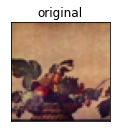

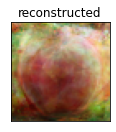

In [7]:
import PIL
from PIL import Image
import numpy as np
import sys
from matplotlib import image
from matplotlib import pyplot as plt
#from google.colab import files
import os.path
from os import path
import pandas as pd


import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model


class Autoencoder(Model):
  '''
  Define the autoencoder with help from the tensorflow library.

  Attributes:
    _latent_dim: The number of latent dimentions the images get mapped onto.
    _epochs: The number of epochs the autoencoder goes through to train.
    encoder: The encoder layers of the autoencoder.
    decoder: The decoder layers of the autoencoder.
  '''
  def __init__(self):
    super(Autoencoder, self).__init__()
    self._latent_dim = 64
    self._epochs = 500
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(self._latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(10800, activation='sigmoid'),
      layers.Reshape((60, 60, 3))
    ])

  def call(self, x):
    '''
    Call the encoder and decoder.
    '''
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

  def set_latent_dim(self, latent_dim):
    '''
    Change number of latent dimentions.
    '''
    self._latent_dim = latent_dim

  def set_epochs(self, epochs):
    '''
    Change number of epochs.
    '''
    self._epochs = epochs


class Controller:
  '''
  Generic controller for the autoencoder.

  This class should not be used directly, as its get_input method does
  nothing. Instead, this class should be inherited from and the subclass used
  to actually send input to the autoencoder.
  '''

  def get_input(self):
    '''
    Translate input from the user into a the file locations of the images to
    tranform.
    '''
    pass


class TakeInput(Controller):
  '''
  Get input from the user.
  '''

  def get_input(self):
    '''
    Take input from the user and determine if the input is valid and what
    should be done with it.

    Print a prompt for the user and given input, call _invalid_input() or
    return file locations and file names to be used in the FormatData class.
    '''
    # Get the path for the folder of training images.
    train_folder_input = input(
        "Enter the path for the folder of training images: ")
    train_folder = train_folder_input.strip()

    # Get the type of fruit they want to train on.
    train_image_input = input(
        "Enter the name of the images you want the autoencoder to train on: ")
    train_image = train_image_input.strip()

    # Get the number of images to train on.
    train_num_input = input("Enter the number of training images: ")
    train_num = train_num_input.strip()

    if self._check_train_input(train_folder, train_image, train_num):
      self._invalid_input()
    train_num = int(train_num)

    # Get the path for the folder of the user image(s).
    test_folder_input = input(
        "Enter the folder path for the image(s) you want to transform: ")
    test_folder = test_folder_input.strip()

    # Get the name of the image(s) to transform.
    test_image_input = input(
        "Enter the name of the image(s) you want to transform: ")
    test_image = test_image_input.strip()

    # Get the number of images the user wants to transform.
    test_num_input = input(
      "Enter the number of image(s) you want to transform (1-10): ")
    test_num = test_num_input.strip()

    if self._check_test_input(test_folder, test_image, test_num):
      self._invalid_input()
    test_num = int(test_num)

    return (train_folder, train_image, train_num, test_folder, test_image,
            test_num)

  def _check_train_input(self, train_folder, train_image, train_num):
    '''
    Check that the training input leads to a valid file location and the number
    of images desired is an integer.

    Arguments:
      train_folder: User input for the path to the folder with training images.
      train_image: User input for the name of training images.
      train_num: User input for the number of images to train on (an integer).

    Returns:
      True if there are any issues found with the input and nothing otherwise.
    '''

    # Make sure the train inputs are valid and there is at least one training
    # image in the location provided.
    file_name = (f'{train_image}_{1}.jpg')
    file_location = (f'{train_folder}/{file_name}')
    if not os.path.isfile(file_location):
      return True
    # Make sure the number given is an integer.
    try:
        int(train_num)
    except ValueError:
        return True

  def _check_test_input(self, test_folder, test_image, test_num):
    '''
    Check that the test input has files at all of the locations specified and
    the number of images desired is an integer.

    Arguments:
      train_folder: User input for the path to the folder with testing images.
      train_image: User input for the name of testing images.
      train_num: User input for the number of images to transform (integer from
      1-10).

    returns:
      True if there are any issues found with the input and nothing otherwise.
    '''
    # Make sure the image number input is an integer between 1 and 10.
    try:
        int(test_num)
    except ValueError:
        return True
    test_num = int(test_num)
    if 0 > test_num or test_num > 10:
      return True
    # Make sure the testing inputs are valid and there are files in the
    # location provided.
    for i in range(1, test_num + 1):
      file_name = (f'{test_image}_{i}.jpg')
      file_location = (f'{test_folder}/{file_name}')
      if not os.path.isfile(file_location):
        return True

  def _invalid_input(self):
    '''
    Print an error message if user input is invalid and run the get_input
    function again.
    '''
    print("Invalid input. Please try again.")
    self.get_input()


class View:
  """
  Generic view for the autoencoder.

  This class should not be used directly, as its methods do nothing. Instead,
  this class should be inherited from and the subclass used to actually
  display the images.
  """
  def display_input(self, images, num_images):
    '''
    Display original input image(s).
    '''
    pass

  def display_output(self, decoded, num_images):
    '''
    Display output image(s).
    '''
    pass


class ViewImages(View):
  '''
  Display the input images and their output after going through the
  autoencoder.
  '''

  def display_input(self, images, num_images):
    '''
    Display original input image(s).
    '''
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
      ax = plt.subplot(2, num_images, i + 1)
      plt.imshow(images[i])
      plt.title("original")
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
    plt.show()

  def display_output(self, decoded, num_images):
    '''
    Display output image(s).
    '''
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
      ax = plt.subplot(2, num_images, i + 1 + num_images)
      plt.imshow(decoded[i])
      plt.title("reconstructed")
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)


class FormatData:
  '''
  Format image data for use in the autoencoder.

  Attributes:
    _file_location: Folder path for images.
    _image_name: Name of all images.
    _image_size: Pixel dimention for square images.
  '''
  def __init__(self):
    self._file_location = '/content/drive/MyDrive/Colab Notebooks/train'
    self._image_name = 'orange'
    self._image_size = 60

  def set_file_location(self, file_location):
    '''
    Define the location of the image files.
    '''
    self._file_location = file_location

  def set_image_name(self, image_name):
    '''
    Define the name for all the image. This assumes images used all have the
    same name with numbers after (ex. 'image_1.jpg', 'image_2.jpg', etc.)
    '''
    self._image_name = image_name

  def set_image_size(self, image_size):
    '''
    Define the dimention of input and output images.
    '''
    self._image_size = image_size

  def _get_image(self, image_num):
    '''
    Get individual image file.

    Arguments:
      image_num: An integer representing the number of the image desired.

    Returns:
      A Pillow image.
    '''
    file_name = (f'{self._image_name}_{image_num}.jpg')
    file_location = (f'{self._file_location}/{file_name}')
    if not os.path.isfile(file_location):
      return False
    else:
      im = Image.open(file_location)
      im = im.convert('RGB')
      return im

  def _square_image(self, image):
    '''
    Crop image into a squre with the dimentions defined by _image_size.

    Arguments:
      image: A Pillow image.

    Returns:
      A square Pillow image with the specified pixel dimentions.
    '''
    width, height = image.size
    # Determine if width or height is smaller.
    if width >= height:
      min_dimention = height
    else:
      min_dimention = width
    # Crop the image evenly on all sides.
    width_1 = int((width - min_dimention) / 2)
    height_1 = int((height - min_dimention) / 2)
    box = (width_1, height_1, width - width_1, height - height_1)
    image_cropped = image.crop(box)
    image = image_cropped.resize((self._image_size, self._image_size))
    return image

  def _get_vector(self, image):
    '''
    Return an image as a vector of values between 0 and 1.

    Arguments:
      image: A Pillow image.

    Returns:
      The image as a numpy array of values between 0 and 1.
    '''
    vector = np.ravel(np.asarray(image)) / 255
    return vector

  def get_image_set(self, num_images):
    '''
    Return a matrix of images given the number of images desired.

    Arguments:
      num_images: An integer representing the number of images the function
      will look for.

    Returns:
      A numpy array of values representing multiple images.
    '''
    image_count = num_images
    image = self._get_image(1)
    crop = self._square_image(image)
    vector_all = self._get_vector(crop)
    if num_images > 1:
      for i in range(2, num_images + 1):
        # If there is not an image at one of the locations specified, skip it and
        # change the number of images so the final matrix is the correct
        # dimentions.
        if not self._get_image(i):
          image_count -= 1
          continue
        else:
          image = self._get_image(i)
          crop = self._square_image(image)
          vector = self._get_vector(crop)
          vector_all = np.vstack((vector_all, vector))
    return np.reshape(vector_all, ((image_count), self._image_size, self._image_size, 3))


def main():
  '''
  Run the software to train on a set of images and transform a new set of one
  or more images.
  '''
  autoencoder = Autoencoder()
  controller = TakeInput()
  display = ViewImages()
  data = FormatData()

  response = controller.get_input()
  if response is not None:
    train_folder, train, train_num, test_folder, test, test_num = response
    data.set_file_location(train_folder)
    data.set_image_name(train)
    train_images = data.get_image_set(train_num)
    data.set_file_location(test_folder)
    data.set_image_name(test)
    user_images = data.get_image_set(test_num)

    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
    autoencoder.fit(train_images, train_images,
                    epochs=500,
                    shuffle=True,
                    validation_data=(user_images, user_images))
    encoded = autoencoder.encoder(user_images).numpy()
    decoded = autoencoder.decoder(encoded).numpy()
    display.display_input(user_images, test_num)
    display.display_output(decoded, test_num)


def function(num):
  return num + 1


if __name__ == "__main__":
  main()

# Likely folder paths
# /content/drive/MyDrive/Colab Notebooks/train
# /content/drive/MyDrive/Colab Notebooks/test
